## Connections

Each endpoint of a network connection is always represented by a **host** and **port #**

In Python you write it out as a tuple (host, port)  
* ("www.python.org", 80)  
* ("205.172.13.4", 443)  

In almost all of the network programs you'll write, you use this convention to specify a network address

## Client/Server Concept

Each endpoint is a running program

Servers wait for incoming connections and provide a service (e.g. web, mail etc.)

Clients make connections to servers

## Request/Response Cycle

Most network programs use a requests/response model based on messages

Client sends a request message (e.g HTTP)
```bash
GET /index.html HTTP/1.0
```

Server sends back a response message
```bash
HTTP/1.0 200 OK
Content-type: text/html
Content-length: 48824

<HTML>
...
```

## Data Transport

There are two basic types of communication

**Streams (TCP)**: Computeres establish a connection with each other and
read/write data in a continuous stream of bytes - like a file. This is the most common.

**Datagrams (UDP)**:Computers send discrete packets (or messages) to each other.
Each packet contains a collection of bytes, but each packet is separate and self-contained.

## Sockets

* Programming abstraction for network code
* Socket: A communication endpoint
* Allows connections to be made and data to be transmitted in either direction

## Socket basics

In [1]:
import socket

In [2]:
# Address families
socket.AF_INET  # Internet Protocol (IPv4)
socket.AF_INET6 # Internet Protocol (IPv6)

<AddressFamily.AF_INET6: 30>

In [3]:
# Socket types
socket.SOCK_STREAM # Connection based stream (TCP)\
socket.SOCK_DGRAM  # Datagrams (UDP)

<SocketKind.SOCK_DGRAM: 2>

In [4]:
# Almost all code will use something like
from socket import *
s = socket(AF_INET, SOCK_STREAM)

## Using a Socket

* Server - listen for incoming  connections
* Client - make an outgoing connection

## TCP Client

In [ ]:
from socket import *
s = socket(AF_INET, SOCK_STREAM)
s.connect(("www.python.org", 80))
s.send(b"GET /index.html HTTP/1.0\n\n")
data = s.recv(10000)
s.close()

## TCP Server

* Must listen for incoming connections on a well-known port
* typically run forever in a server-loop
* may have to service multiple client

In [ ]:
from socket import *
s = socket(AF_INET, SOCK_STREAM)
# bind socket to a specific address
s.bind(("", 9000)) # binds to localhost
s.listen(5)
while True:
    conn, addr = s.accept()
    print(f'Recevied connection from {addr}')
    msg = f'Hello {addr}'
    conn.send(msg.encode())
    conn.close()

If system has multiple IP addresses, can bind to a specific address, e.g.  
```python
s.bind(("104.21.4.2",9000))
```

Tell operating system to start listening for connections on the socket
```python
s.listen(5)
```
* s.listen(backlog)
* blacklog is # of pending connecitons to allow
* not related to max number of clients

Accepting a new conneciton
```python
conn, addr = s.accept()
```
* `s.accept()` blocks until connection received
* server sleeps if nothing is happening
* accept returns a pair (client_socket, address)

Sending data back to client
```python
conn.send()
```
* use the client socket for transmitting data.
* The server socket is only used for accepting new connections.

## Partial Reads/Writes

* be aware that reading/writing to a socket may involve partial data transfer
* `send()` returns actual bytes sent
* `recv()` length is only a maximum limit

* be aware that for TCP, the data stream is continuous - no concept of records

This `recv()` may return data from both of the sends combined or less data than even the first send

## Sending All Data

* to wait until data is sent, use `sendall()`
```python
s.sendall(data)
```
* blocks until all data is transmitted
* for most normal applications, this is what you should use
* You don't use this if networking is mixed in with other kinds of processing

## End of Data
* How to tell if there is no more data?
* `recv()` will return empty string
```python
>>> s.recv(1000)
''
>>>
```
* this means that the other end of the conneciton has been close (no more sends)

## Data Reassembly

Receivers often need to reassemble messages from a series of small chunks

In [ ]:
fragments = []
while not done:
    chunk = s.recv(maxsize)
    if not chunk:
        break
    fragments.append(chunk)
    
message = "".join(fragments)

## Timeouts

* Most socket operations block indefinitely
* can set an optional timeout
```python
s = socket(AF_INET, SOCK_STREAM)
s.settimeout(5.0)
```
* disabling timeouts
`s.settimeout(None)`

## Non-blocking Sockets

* Instead of timeouts, can set non-blocking  
`s.setblocking(False)`

## Socket Options

* Sockets have a large number of parameters
* Example: Reusing the port number
```python
s.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
```

# Sockets and Concurrency

* Servers usually handle multiple clients
* Each client gets its own socket on server
```python
...
while True:
    conn, addr = s.accept()
    ...
```
* new connections make a new socket

* To manage multiple clients
    * server must always be ready to accept new connections
    * must allow each client to operate independently (each may be performing different tasks on the server)
    

## Threaded Server

Each client is handled by a separate thread

In [ ]:
import threading
from socket import *

def handle_client(c):
    ... whatever...
    c.close()
    return

s = socket(AF_INET, SOCK_STREAM)
s.bind(('', 9000))
s.listen(5)
while True:
    conn, addr = s.accept()
    t = threading.Thread(target=handle_client, args=(conn,))

## Forking server

Each client is handled by a subprocess

In [ ]:
import os
from socket import *

s = socket(AF_INET, SOCK_STREAM)
s.bind(('', 9000))
s.listen(5)
while True:
    conn, addr = s.accept()
    if os.fork() == 0:
        # Child proccess, manage client
        ...
        conn.close()
        os._exit(0)
    else:
        # Parent process. Clean up and go
        # back to wait for more connections
        conn.close()

## Asynchronous Server

Server handles all clients in an event loop

In [ ]:
import select
from socket import *

s = socket(AF_INET, SOCK_STREAM)
...

clients = []
while True:
    # Look for activity on any of my sockets
    input, output, err = select.select(s+clients, clients, clients)
    # Process all sockets with input
    for i in input:
        ...
    # Process all sockets ready for output
    for o in output:
        ...

## Utility functions

Get the hostname of the local machine

In [5]:
import socket

In [6]:
socket.gethostname()

'MacBook-Air-Marcin.local'

Get the IP address of a remote machine

In [7]:
socket.gethostbyname('www.python.org')

'151.101.112.223'

Get name information on a remote IP

In [8]:
socket.gethostbyaddr("8.8.8.8")

('dns.google', ['8.8.8.8.in-addr.arpa'], ['8.8.8.8'])

# Web Programming Basics

## HTTP Explained

* HTTP is the underlying protocol of the web
* Consists of requests and responses

Request
```bash
GET /index.html HTTP/1.1
```
Response
```bash
HTTP/1.1 200 OK
...
<content>
```


## HTTP Protocol

There are a number of requests types
- `GET`
- `POST`
- `HEAD`
- `PUT`  
...

There are standardized response codes
* `200 OK`
* `403 Forbidden`
* `404 Not Found`
* `501 Not Implemented`

## Content Encoding

Content is descibed by these header fields:  
    `Content-type:`  
    `Content-length:`

Example:  
```bash
Content-type: image/jpeg
Content-length: 12422
```

## Typical Python Tasks

**Static content generation** - One-time generation of static web pages to be served by a standard web server such as Apache.

**Dynamic content generation** - Python scripts that produce output in response to requests (e.g. , form processing, CGI scripting)

## A Simple Web Server

Serve files form a directory

In [ ]:
from http.server import HTTPServer
from http.server import SimpleHTTPRequestHandler
import os

pwd = os.getcwd()
os.chdir(f'{pwd}')
serv = HTTPServer(("", 9876), SimpleHTTPRequestHandler)
serv.serve_forever()

Connect with a browser and try it out!

## CGI Scripting

* Common Gateway Interface
* A common protocol used by existing web servers to run server-side scripts, plugins etc
* Example: running Python, Perl, Ruby scripts under Apache
* Classically associated with form processing but that's far from the only applicaiton

## CGI Mechanics

* CGI was originally implemented as a scheme for launching processing scripts as a subprocess to a web server

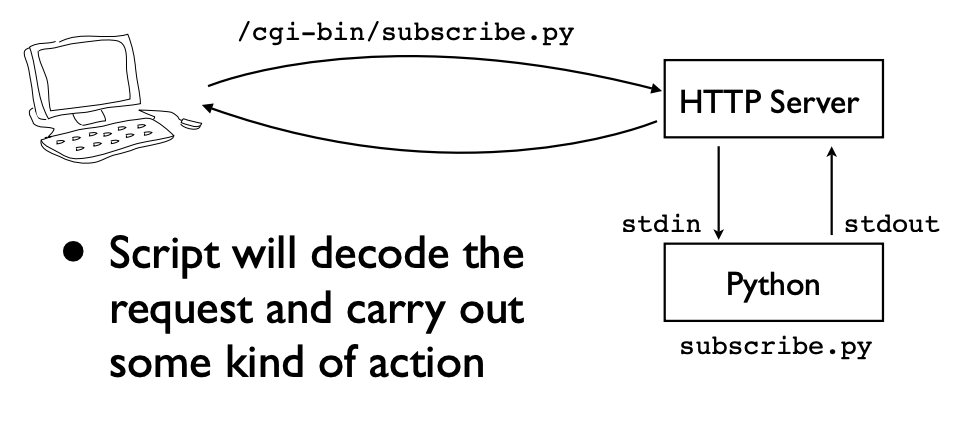

In [9]:
from IPython.display import Image
Image("images/cgi.png")

## Classic CGI Interface

* Server populates environment variables with information about the request  

```python
import os
os.environ['SCRIPT_NAME']
os.environ['REMOTE_ADDR']
os.environ['QUERY_STRING']
os.environ['REQUEST_METHOD']
os.environ['CONTENT_TYPE']
os.environ['CONTENT_LENGTH']
os.environ['HTTP_COOKIE']
```

* stdin/stdout provide I/O link to server
```python
sys.stdin  # Read to get data sent by client
sys.stdout # Write to create the response
```

## WSGI

* Web Services Gateway Interface (WSGI)
* This is a standardized interface for creating
* Allows one to create code that can run under a wide variety of
web servers and frameworks as long as the also support WSGI

## WSGI Interface

* WSGI is an application programming interface loosely based on CGI programming
* In CGI, there are just two basic features:
    * getting values on inputs (env variables)
    * producing output by printing
* WSGI takes this concept and repackages it into a more modular form


## WSGI Example

* With WSGI, you write an "application"
* An application is just a function (or callable)
```python
def hello_app(environ, start_response):
    status = "200 OK"
    response_headers = [('Content-type', 'test/plain')]
    response = []
    
    start_response(status, response_headers)
    response.append("Hello World\n")
    response.append("You requested: " + environ["PATH_INFO"])
    return response
```
* this function encapsulates the handling of some request that will be received

## WSGI Applications

* Applications always receive just two inputs
```python
def hello_app(environ, start_response):
```
* environ -  a dictionary of input parameters
* start_response - a callable (e.g. function)

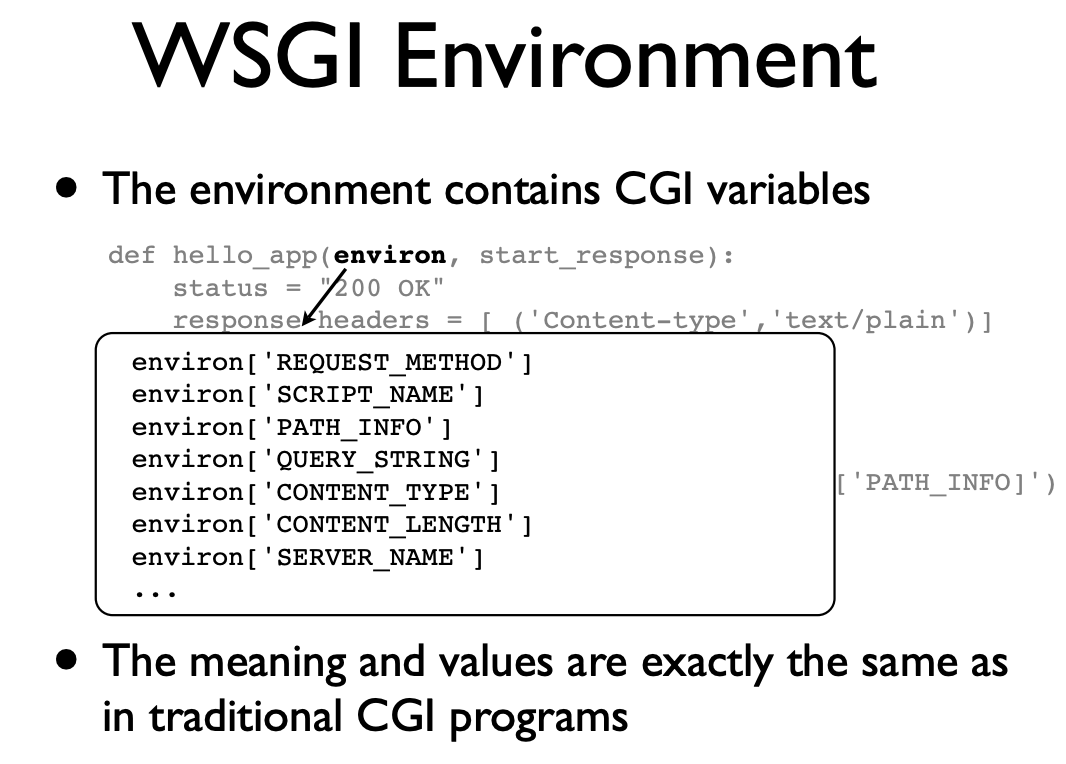

In [10]:
Image("images/wsgi1.png")

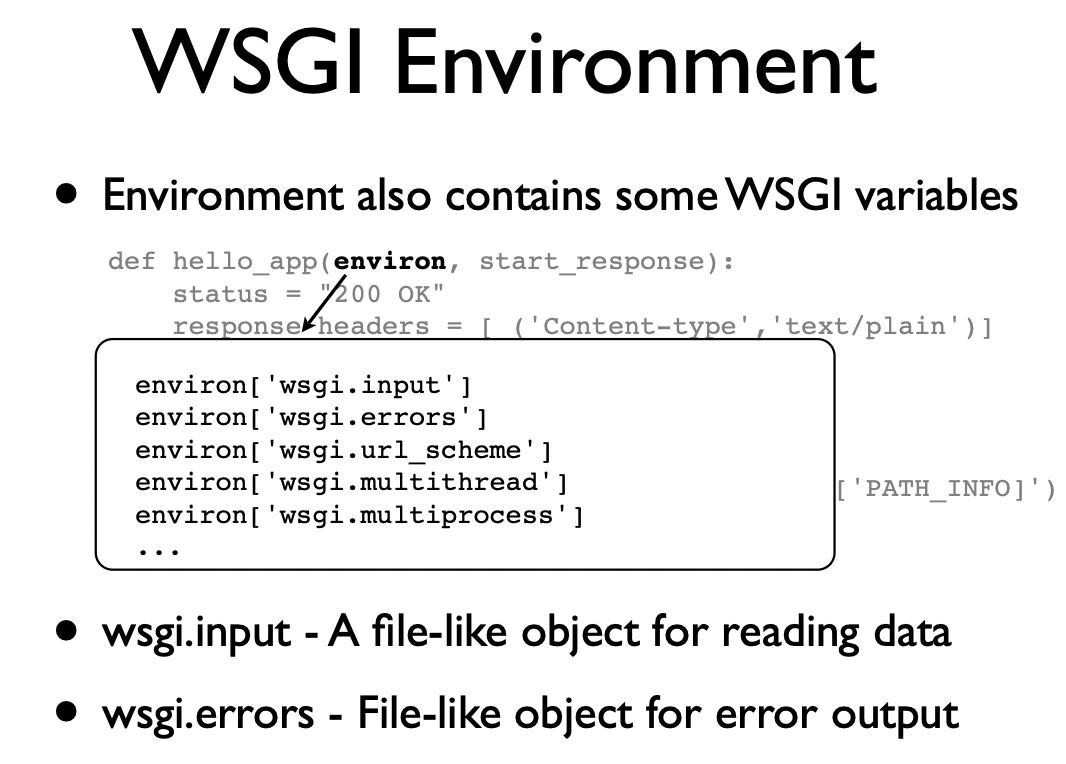

In [11]:
Image("images/wsgi2.png")

## WSGI Responses
* `start_response()` - a hook back to the server
* gives the server information for formulating the response (status, headers, etc.)
* prepares the server for receiving content data

In [ ]:
def hello_app(environ, start_response):
    status = "200 OK"
    response_headers = [("content-type", "text/html")]
    
    start_response(status, response_headers)
    return [u"That's a spicy Jalape\u00f1o".encode('utf-8')]

## WSGI Content
* Content is returned **as a sequence of byte strings**  

```python
response = []

response.append("Hello World\n")
response.append("You requested: " + environ['PATH_INFO'])
return response
```
* Note: This differs from CGI programming where you produce output using print.

## WSGI Content Encoding
* WSGI applications must always produce bytes
* If working with Unicode, it must be encoded
                   

## WSGI Deployment
* The main point of WSGI is to simplify deployment of web applications
* You will notice that the interface depends on no third party libraries, no objects, or even any standard library modules
* That is intentional. WSGI apps are supposed to be small self-contained units that plug into other environments

* Running a simple stand-alone WSGI server

In [ ]:
from wsgiref import simple_server
httpd = simple_server.make_server("", 9001, hello_app)
httpd.serve_forever()

# Advanced Networking

## SocketServer

* A module for writing custom servers
* Supports TCP and UDP networking
* The module aims to simplify some of the low-level details of working with sockets and to put all of that functionality in one place

## SocketServer Example
* To use SocketServer, you define handler objects using classes
* Example: A time server

In [ ]:
import socketserver
import time

class TimeHandler(socketserver.BaseRequestHandler):
    def handle(self):
        self.request.sendall(b'hi mom')
        
serv = socketserver.TCPServer(("", 9005), TimeHandler)
serv.serve_forever()

## Execution Model
* Server runs in a loop waiting for requests
* On each connection, the server creates a **new instantiation** of the handler class
* the handle() method is invoked to handle the logic of communicating with the client
* when handle() returns, the connection is closed and the handler instance si destroyed

## XML-RPC
* Remote Procedure Call
* Uses HTTP as a transpoer protocol
* Parameters/Results encoded in XML
* Supported by languages other than Python 

## Simple XML-RPC
* How to create a stand-alone server

In [ ]:
from xmlrpc.server import SimpleXMLRPCServer

def add(x, y):
    return x + y

s = SimpleXMLRPCServer(("", 8082))
s.register_function(add)
s.serve_forever()

Test

In [ ]:
import xmlrpc.client
s = xmlrpc.client.ServerProxy("http://localhost:8082")
s.add(3,5)

* Adding multiple function
```python
s = SimpleXMLRPCServer(("",8080))
s.register_function(add)
s.register_function(foo)
s.register_function(bar)
s.serve_forever()
```

## Serializing Python Objects
* In distributed applications, you may want to pass various kinds of Python objects around
* Libraries such as XML-RPC support simple data types, but not anything more complex
* However, serilizing arbitrary Python objects into byte-string is quite simple

## Miscellaneous Comments
* Pickle is really only useful if used in a Python-only environment
* Would not use if you need to communicate to other programming languages
* There are also security concerns
* Never use pickle with untrusted clients